In [16]:
# Standard Libararies
import os
import time
import random
import textwrap
import numpy as np
import pandas as pd


from skimage import io, transform, morphology, measure, filters
from skimage.color import rgb2gray

# Progress Bars
from tqdm import tqdm

# Neueral Networks
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

# Plotting and Image Processing
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize

# Memory Optimization
from joblib import dump
from joblib import load
import gc

In [2]:
print("Using torch", torch.__version__)

Using torch 2.4.0.post101


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

mps_avail = torch.backends.mps.is_available()
print(f"Is the Mac MPS (GPU for Mac) available? {mps_avail}")

if(gpu_avail):
    device = "cuda"
elif(mps_avail):
    device = "mps"
else:
    device = "cpu"

Is the GPU available? False
Is the Mac MPS (GPU for Mac) available? True


In [4]:
training_classifications = 'training_classifications.csv'
training_classifications_df = pd.read_csv('training_classifications.csv')
training_classifications_df

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.000000,0.000000,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.000000,0.000000,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.000000,0.000000,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61573,999948,0.510379,0.489621,0.000000,0.059207,0.430414,0.000000,0.430414,0.226257,0.204157,...,0.000000,0.226257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.226257
61574,999950,0.901216,0.098784,0.000000,0.000000,0.098784,0.000000,0.098784,0.000000,0.098784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61575,999958,0.202841,0.777376,0.019783,0.116962,0.660414,0.067245,0.593168,0.140022,0.520391,...,0.000000,0.000000,0.090673,0.049349,0.000000,0.067726,0.000000,0.000000,0.0,0.072296
61576,999964,0.091000,0.909000,0.000000,0.045450,0.863550,0.022452,0.841098,0.795330,0.068220,...,0.000000,0.068398,0.318132,0.408799,0.227464,0.408799,0.090668,0.023065,0.0,0.045334


In [6]:
os.listdir('training_images')[0]

'873932.jpg'

In [13]:
# Function to add white border around plots for ease of visibility
def add_subplot_border(ax, width=1, color=None):

    fig = ax.get_figure()

    # Convert bottom-left and top-right to display coordinates
    x0, y0 = ax.transAxes.transform((0, 0))
    x1, y1 = ax.transAxes.transform((1, 1))

    # Convert back to Axes coordinates
    x0, y0 = ax.transAxes.inverted().transform((x0, y0))
    x1, y1 = ax.transAxes.inverted().transform((x1, y1))

    rect = plt.Rectangle(
        (x0, y0), x1-x0, y1-y0,
        color=color,
        transform=ax.transAxes,
        zorder=-1,
        lw=2*width+1,
        fill=None,
    )
    fig.patches.append(rect)

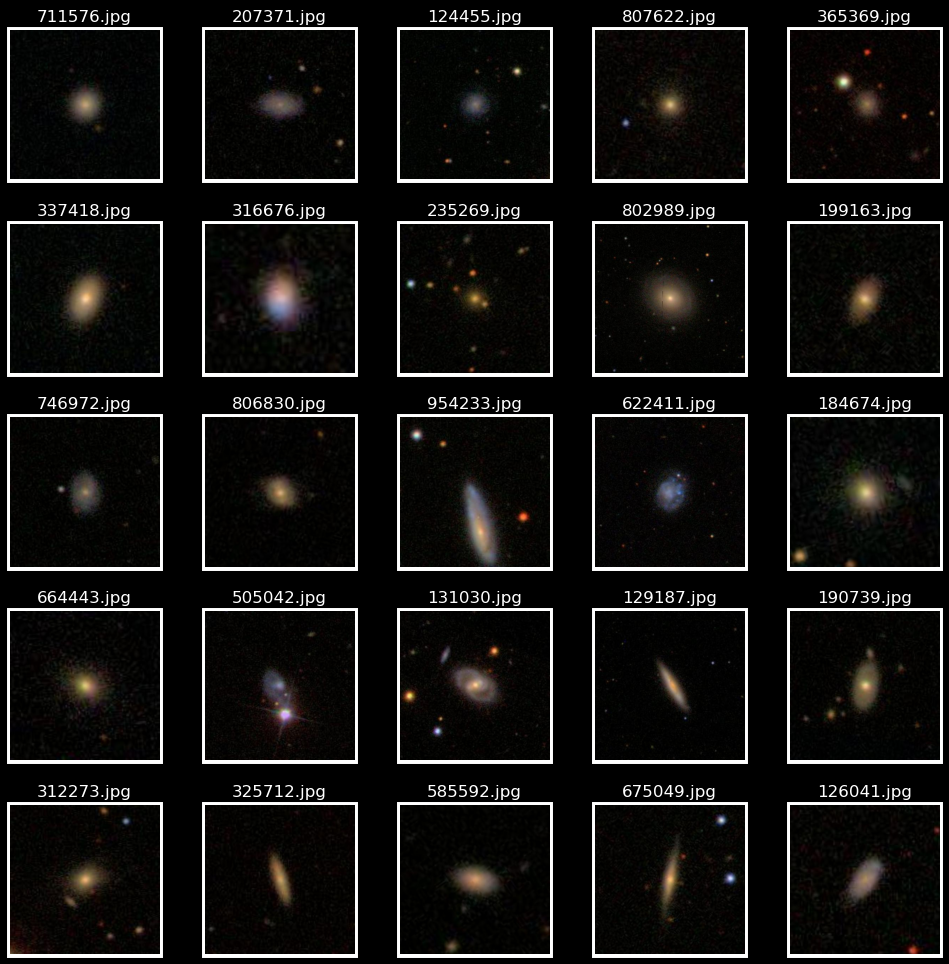

In [14]:
# Use dark background
plt.style.use('dark_background')

# Plot the 25 randomly selected images
random.seed(42)

root = "../../desktop/research/training_images"
cols, rows = 5, 5

# Make a new figure and define dark themed style
figure = plt.figure(figsize=(12,12))

# Create plotted filenames array for later
plotted_images = []

for i in range(1, cols * rows + 1):
    rand_idx = random.randint(0, 61577)
    ax = figure.add_subplot(rows, cols, i)
    filename = f"{training_classifications_df['GalaxyID'].iloc[rand_idx]}.jpg"
    img = plt.imread(os.path.join(root, filename))
    plotted_images.append(img)
    plt.imshow(img)
    plt.title(f"{filename}")
    plt.axis('off')
    add_subplot_border(ax, width=2, color='white')

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [19]:
classification_names = ['GalaxyID',
                        'Amount of Smoothness for a disk',
                        'Signs of features or a disk',
                        'Classified as Star or Artifact',
                        'Disk can be viewed edge-on',
                        'Disk cannot be viewed edge-on',
                        'Bar or feature through centre of galaxy detected',
                        'Bar or feautre through centre of galaxy not detected',
                        'Signs of a spiral arm pattern',
                        'No signs of a spiral arm pattern',
                        'No bulge',
                        'Just noticeable bulge',
                        'Obvious bulge',
                        'Dominant bulge',
                        'Odd features in image',
                        'No odd features in image',
                        'Completely round',
                        'In-between round and cigar',
                        'Cigar-shaped',
                        'Presence of Ring',
                        'Presence of lens or arc',
                        'Disturbed galaxy',
                        'Irregular galaxy',
                        'Presence of other odd features',
                        'Merger galaxies',
                        'Presence of dust lane',
                        'Rounded bulge at centre',
                        'Boxy bulge at centre',
                        'No bulge at centre',
                        'Tight spiral arms',
                        'Medium spiral arms',
                        'Loose spiral arms',
                        '1 spiral arm',
                        '2 spiral arms',
                        '3 spiral arms',
                        '4 spiral arms',
                        'More than 4 spiral arms',
                        'Can\'t tell if any spiral arms exist']

# define variable to store number of lables
num_labels = len(training_classifications_df.dtypes.index.tolist())

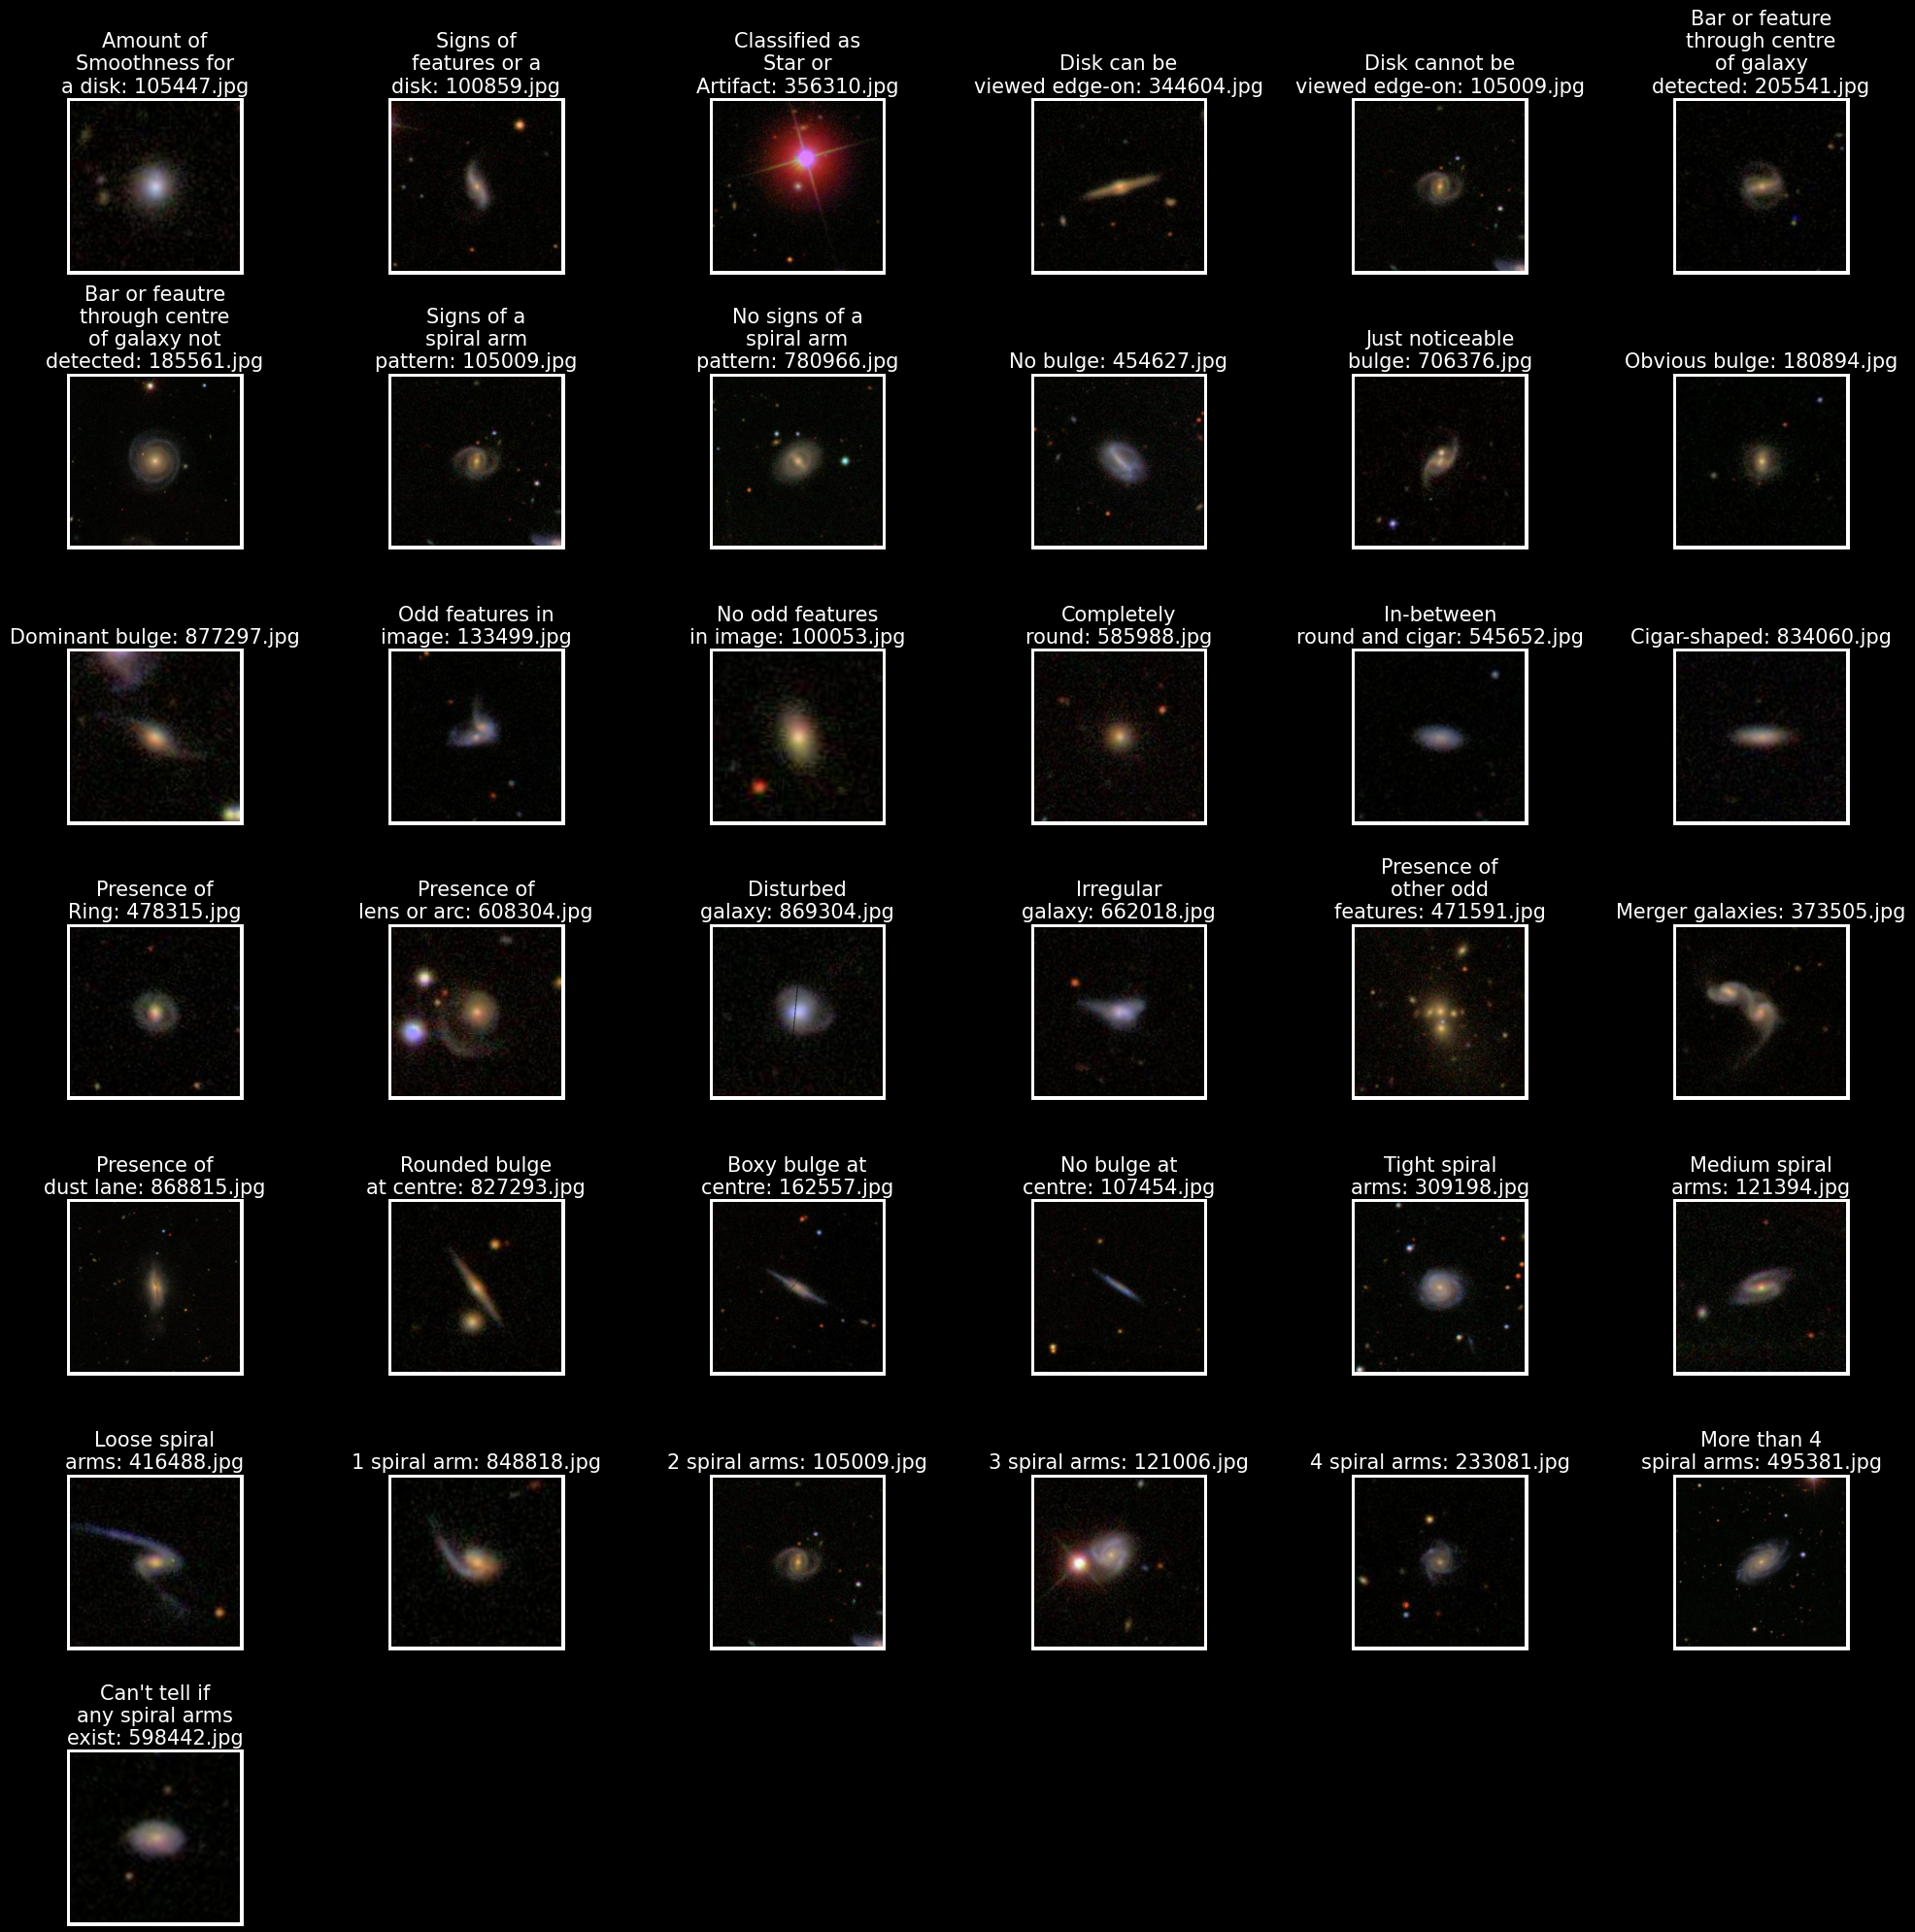

In [20]:
def wrap_title(text, width):
    return "\n".join(textwrap.wrap(text, width=width))

max_rows = training_classifications_df.idxmax()
maxxed_df = training_classifications_df.loc[max_rows]
rows, cols = 7, 6

# Make a new figure and define dark themed style
figure = plt.figure(figsize=(20, 20))  # Increased figure size for larger images
plt.style.use('dark_background')

for i in range(1, len(maxxed_df)):
    ax = figure.add_subplot(rows, cols, i)
    filename = f"{maxxed_df['GalaxyID'].iloc[i]}.jpg"
    img = plt.imread(os.path.join(root, filename))
    plt.imshow(img)
    plt.title(f"{wrap_title(classification_names[i], width=15)}: {filename}", fontsize=15)
    plt.axis('off')
    add_subplot_border(ax, width=2, color='white')

plt.tight_layout()
plt.show()